<a href="https://colab.research.google.com/github/gayatribandaru/CMPE255_Team_Project_InsightfulMiners/blob/main/Cross_Language_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement

The objective of this InsightfulMiners team-led endeavor is to establish a resilient framework for cross-language topic modeling. The objective is to improve comprehension of multilingual content through the precise and efficient mapping of topics across documents written in various languages.


## Objectives specified are

- Import and Process Multilingual Data
- Model Training
- Topic Discovery
- Cross-Language Topic Prediction
- Made Topic modeling compatible with TF-IDF outputs
- Utilization of Machine Translation

## Outcomes :

### Identified Topics in Multilingual Dataset:

Focusing specifically on the German queries, the principal deliverable will consist of a compilation of subjects extracted from the dataset.

### Model Performance Metrics:

The essential outcome of the model will be the coherence scores, which will indicate the quality and interpretability of the topics identified by the topic model. A greater coherence score indicates that the topics are more significant and varied.

### Insights from Topic Distribution:

Insights regarding the distribution of various topics throughout the dataset. This involves comprehending the representation of the most prevalent topics and their frequency within the text.

### Cross-Language Topic Modeling Validation:

The efficacy of the model in managing and forecasting subjects in various languages, with a specific focus on French, German, and Italian. This process entails evaluating the model's capacity for generalization and conducting topic modeling on languages that were not incorporated during the training stage.

### Translation and Comparative Analysis:

The application of the machine translation library implies that in order to facilitate comparative analysis, the model's inputs or outputs are translated. This approach may facilitate comprehension of the manner in which subjects are depicted in various languages and may also improve the findings' accessibility for a more extensive readership.

### Visual Representations and Interpretations:

The production of graphical depictions, including word clouds and topic distribution charts, facilitates an instinctive comprehension of the subjects and their importance within the dataset.

### Documented Findings and Conclusions:

The endeavor is anticipated to reach its pinnacle in the form of a documented report or presentation that outlines the discoveries. This will comprise the performance and applicability of the model across various languages, in addition to the identified important topics, their significance, and implications.


# Data Import and Initial Exploration

# Installing Contextualized Topic Models

First, we install the contextualized topic model library

In [ ]:
%%capture
!pip install contextualized_topic_models

##Import data

Let us import the questions in German


In [ ]:
import pandas as pd

!wget https://raw.githubusercontent.com/gayatribandaru/CMPE255_Team_Project_InsightfulMiners/main/questions.de.jsonl
result = pd.read_json(path_or_buf='/content/questions.de.jsonl', lines=True)
result.head()

--2023-12-16 06:43:20--  https://raw.githubusercontent.com/gayatribandaru/CMPE255_Team_Project_InsightfulMiners/main/questions.de.jsonl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34262 (33K) [text/plain]
Saving to: ‘questions.de.jsonl’

questions.de.jsonl  100%[===================>]  33.46K  --.-KB/s    in 0.003s  

2023-12-16 06:43:21 (13.1 MB/s) - ‘questions.de.jsonl’ saved [34262/34262]



,id,text,topic
0,2,"Finden Sie es grundsätzlich richtig, dass der ...",Welfare
1,4,Soll zusätzlich zur bestehenden Mutterschaftsv...,Welfare
2,6,Die Invalidenversicherung spricht bei nicht ob...,Welfare
3,7,Würden Sie eine nationale Spitalplanung befürw...,Healthcare
4,9,"Finden Sie es richtig, dass einzelne ärztliche...",Healthcare


In [ ]:
result['topic'].unique()

array(['Welfare', 'Healthcare', 'Education', 'Immigration', 'Society',
       'Security', 'Finances', 'Economy', 'Foreign Policy',
       'Infrastructure & Environment', 'Political System', 'Digitisation'],
      dtype=object)

Let's drop the duplicates.

In [ ]:
result = result.drop_duplicates(subset=['text'])
result

,id,text,topic
0,2,"Finden Sie es grundsätzlich richtig, dass der ...",Welfare
1,4,Soll zusätzlich zur bestehenden Mutterschaftsv...,Welfare
2,6,Die Invalidenversicherung spricht bei nicht ob...,Welfare
3,7,Würden Sie eine nationale Spitalplanung befürw...,Healthcare
4,9,"Finden Sie es richtig, dass einzelne ärztliche...",Healthcare
...,...,...,...
189,3464,Würden Sie eine Ausdehnung der rechtlichen Mög...,Security
190,3468,Soll die Schweiz Verhandlungen über den Beitri...,Foreign Policy
191,3469,Soll der Bundesrat ein Freihandelsabkommen mit...,Foreign Policy
192,3470,"Eine Initiative fordert, dass die Haftungsrege...",Foreign Policy


## Importing what we need

In [ ]:
from contextualized_topic_models.models.ctm import ZeroShotTM, CombinedTM
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessingStopwords
import nltk
import torch
import random
import numpy as np

We are going to create a function that fixes the random seeds so that we can replicate the results. We will use this function later.

In [ ]:
def fix_seeds():
  torch.manual_seed(10)
  torch.cuda.manual_seed(10)
  np.random.seed(10)
  random.seed(10)
  torch.backends.cudnn.enabled = False
  torch.backends.cudnn.deterministic = True

# Data Cleaning and Preprocessing

In [ ]:
from nltk.corpus import stopwords as stop_words
nltk.download('stopwords')
stopwords = list(set(stop_words.words('english')))
documents = result.text.tolist()
sp = WhiteSpacePreprocessingStopwords(documents, stopwords_list=stopwords)
preprocessed_documents, unpreprocessed_corpus, vocab, another_variable = sp.preprocess()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Let's check the first ten words of the vocabulary

In [ ]:
vocab[:10]

['heliskiing',
 'waffen',
 'erschwert',
 'saule',
 'pro',
 'schienennetzes',
 'spatestens',
 'anforderungen',
 'uber',
 'sollen']

In [ ]:
preprocessed_documents[:5]

['finden sie es grundsatzlich richtig dass der staat die fremdbetreuung von kindern finanziell unterstutzt mit steuerabzugen oder subventionen',
 'soll zusatzlich zur bestehenden mutterschaftsversicherung ein wochiger elternurlaub elternzeit eingefuhrt werden',
 'die invalidenversicherung spricht bei nicht objektiv nachweisbaren schmerzstorungen als folge eines schleudertraumas keine iv renten mehr zu finden sie dies richtig',
 'wurden sie eine nationale spitalplanung befurworten die auch zur schliessung von spitalern fuhren kann',
 'finden sie es richtig dass einzelne arztliche leistungen der komplementarmedizin alternativmedizin wieder von der grundversicherung vergutet werden']

In [ ]:
unpreprocessed_corpus[:5]

['Finden Sie es grundsätzlich richtig, dass der Staat die Fremdbetreuung von Kindern finanziell unterstützt (mit Steuerabzügen oder Subventionen)?',
 'Soll zusätzlich zur bestehenden Mutterschaftsversicherung ein 24-wöchiger Elternurlaub ("Elternzeit") eingeführt werden?',
 'Die Invalidenversicherung spricht bei nicht objektiv nachweisbaren Schmerzstörungen (z.B. als Folge eines Schleudertraumas) keine IV-Renten mehr zu. Finden Sie dies richtig?',
 'Würden Sie eine nationale Spitalplanung befürworten, die auch zur Schliessung von Spitälern führen kann?',
 'Finden Sie es richtig, dass einzelne ärztliche Leistungen der Komplementärmedizin (Alternativmedizin) wieder von der Grundversicherung vergütet werden?']

In [ ]:
tp = TopicModelDataPreparation("paraphrase-distilroberta-base-v2")

training_dataset = tp.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

.gitattributes:   0%|          | 0.00/736 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.74k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/686 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

# Modeling:

**Topic Modeling**

In [ ]:
from contextualized_topic_models.evaluation.measures import CoherenceNPMI, InvertedRBO
corpus = [d.split() for d in preprocessed_documents]

num_topics = [5, 10, 15, 20]
num_runs = 5

best_topic_coherence = -999
best_num_topics = 0
for n_components in num_topics:
  for i in range(num_runs):
    print("num topics:", n_components, "/ num run:", i)
    ctm = CombinedTM(bow_size=len(tp.vocab), contextual_size=768,
                     n_components=n_components, num_epochs=50)
    ctm.fit(training_dataset)
    coh = CoherenceNPMI(ctm.get_topic_lists(10), corpus)
    coh_score = coh.score()
    print("coherence score:", coh_score)
    if best_topic_coherence < coh_score:
      best_topic_coherence = coh_score
      best_num_topics = n_components
    print("current best coherence", best_topic_coherence, "/ best num topics", best_num_topics)

num topics: 5 / num run: 0


Epoch: [50/50]	 Seen Samples: [6400/8650]	Train Loss: 100.86963653564453	Time: 0:00:00.224070: : 50it [00:18,  2.75it/s]
100%|██████████| 3/3 [00:00<00:00,  9.19it/s]


coherence score: -0.3593827112898643
current best coherence -0.3593827112898643 / best num topics 5
num topics: 5 / num run: 1


Epoch: [50/50]	 Seen Samples: [6400/8650]	Train Loss: 99.75168228149414	Time: 0:00:00.135640: : 50it [00:10,  4.84it/s]
100%|██████████| 3/3 [00:00<00:00, 20.41it/s]


coherence score: -0.33066362935463883
current best coherence -0.33066362935463883 / best num topics 5
num topics: 5 / num run: 2


Epoch: [50/50]	 Seen Samples: [6400/8650]	Train Loss: 100.96001052856445	Time: 0:00:00.135804: : 50it [00:08,  6.07it/s]
100%|██████████| 3/3 [00:00<00:00, 21.12it/s]


coherence score: -0.4459530603312666
current best coherence -0.33066362935463883 / best num topics 5
num topics: 5 / num run: 3


Epoch: [50/50]	 Seen Samples: [6400/8650]	Train Loss: 99.02504348754883	Time: 0:00:00.125194: : 50it [00:06,  7.16it/s]
100%|██████████| 3/3 [00:00<00:00, 20.99it/s]


coherence score: -0.33861366950345567
current best coherence -0.33066362935463883 / best num topics 5
num topics: 5 / num run: 4


Epoch: [50/50]	 Seen Samples: [6400/8650]	Train Loss: 104.23549270629883	Time: 0:00:00.130512: : 50it [00:08,  6.21it/s]
100%|██████████| 3/3 [00:00<00:00, 21.16it/s]


coherence score: -0.436825671914399
current best coherence -0.33066362935463883 / best num topics 5
num topics: 10 / num run: 0


Epoch: [50/50]	 Seen Samples: [6400/8650]	Train Loss: 101.01452255249023	Time: 0:00:00.200174: : 50it [00:07,  6.75it/s]
100%|██████████| 3/3 [00:00<00:00, 12.42it/s]


coherence score: -0.22125054296517352
current best coherence -0.22125054296517352 / best num topics 10
num topics: 10 / num run: 1


Epoch: [50/50]	 Seen Samples: [6400/8650]	Train Loss: 101.95957565307617	Time: 0:00:00.133477: : 50it [00:07,  6.70it/s]
100%|██████████| 3/3 [00:00<00:00, 21.64it/s]


coherence score: -0.25285675944456776
current best coherence -0.22125054296517352 / best num topics 10
num topics: 10 / num run: 2


Epoch: [50/50]	 Seen Samples: [6400/8650]	Train Loss: 103.2569580078125	Time: 0:00:00.136924: : 50it [00:08,  6.11it/s]
100%|██████████| 3/3 [00:00<00:00, 20.10it/s]


coherence score: -0.20612358467836836
current best coherence -0.20612358467836836 / best num topics 10
num topics: 10 / num run: 3


Epoch: [50/50]	 Seen Samples: [6400/8650]	Train Loss: 104.35292053222656	Time: 0:00:00.133250: : 50it [00:07,  6.51it/s]
100%|██████████| 3/3 [00:00<00:00, 19.93it/s]


coherence score: -0.25716716263687195
current best coherence -0.20612358467836836 / best num topics 10
num topics: 10 / num run: 4


Epoch: [50/50]	 Seen Samples: [6400/8650]	Train Loss: 100.78218841552734	Time: 0:00:00.128619: : 50it [00:08,  6.08it/s]
100%|██████████| 3/3 [00:00<00:00, 20.16it/s]


coherence score: -0.3026613321392204
current best coherence -0.20612358467836836 / best num topics 10
num topics: 15 / num run: 0


Epoch: [50/50]	 Seen Samples: [6400/8650]	Train Loss: 106.23909378051758	Time: 0:00:00.148617: : 50it [00:08,  5.96it/s]
100%|██████████| 3/3 [00:00<00:00, 19.64it/s]


coherence score: -0.21896226430565496
current best coherence -0.20612358467836836 / best num topics 10
num topics: 15 / num run: 1


Epoch: [50/50]	 Seen Samples: [6400/8650]	Train Loss: 103.47917938232422	Time: 0:00:00.145853: : 50it [00:07,  6.81it/s]
100%|██████████| 3/3 [00:00<00:00, 20.19it/s]


coherence score: -0.24351605204473808
current best coherence -0.20612358467836836 / best num topics 10
num topics: 15 / num run: 2


Epoch: [50/50]	 Seen Samples: [6400/8650]	Train Loss: 105.31340789794922	Time: 0:00:00.141068: : 50it [00:08,  5.96it/s]
100%|██████████| 3/3 [00:00<00:00, 19.91it/s]


coherence score: -0.14631138465128207
current best coherence -0.14631138465128207 / best num topics 15
num topics: 15 / num run: 3


Epoch: [50/50]	 Seen Samples: [6400/8650]	Train Loss: 105.31404495239258	Time: 0:00:00.204653: : 50it [00:08,  5.62it/s]
100%|██████████| 3/3 [00:00<00:00, 13.66it/s]


coherence score: -0.22622206610779833
current best coherence -0.14631138465128207 / best num topics 15
num topics: 15 / num run: 4


Epoch: [50/50]	 Seen Samples: [6400/8650]	Train Loss: 104.091796875	Time: 0:00:00.142504: : 50it [00:07,  6.70it/s]
100%|██████████| 3/3 [00:00<00:00, 19.46it/s]


coherence score: -0.3289228343078751
current best coherence -0.14631138465128207 / best num topics 15
num topics: 20 / num run: 0


Epoch: [50/50]	 Seen Samples: [6400/8650]	Train Loss: 108.7672348022461	Time: 0:00:00.153351: : 50it [00:08,  5.91it/s]
100%|██████████| 3/3 [00:00<00:00, 20.00it/s]


coherence score: -0.22123609689892842
current best coherence -0.14631138465128207 / best num topics 15
num topics: 20 / num run: 1


Epoch: [50/50]	 Seen Samples: [6400/8650]	Train Loss: 108.72752380371094	Time: 0:00:00.233805: : 50it [00:08,  6.17it/s]
100%|██████████| 3/3 [00:00<00:00, 11.86it/s]


coherence score: -0.23080743310569476
current best coherence -0.14631138465128207 / best num topics 15
num topics: 20 / num run: 2


Epoch: [50/50]	 Seen Samples: [6400/8650]	Train Loss: 110.16560363769531	Time: 0:00:00.145676: : 50it [00:07,  6.44it/s]
100%|██████████| 3/3 [00:00<00:00, 17.98it/s]


coherence score: -0.25089278365412254
current best coherence -0.14631138465128207 / best num topics 15
num topics: 20 / num run: 3


Epoch: [50/50]	 Seen Samples: [6400/8650]	Train Loss: 102.76557159423828	Time: 0:00:00.298097: : 50it [00:15,  3.31it/s]
100%|██████████| 3/3 [00:00<00:00, 11.56it/s]


coherence score: -0.22464444751870438
current best coherence -0.14631138465128207 / best num topics 15
num topics: 20 / num run: 4


Epoch: [50/50]	 Seen Samples: [6400/8650]	Train Loss: 105.0440559387207	Time: 0:00:00.222748: : 50it [00:15,  3.21it/s]
100%|██████████| 3/3 [00:00<00:00, 12.26it/s]


coherence score: -0.23166142918886581
current best coherence -0.14631138465128207 / best num topics 15


In [ ]:
fix_seeds()

num_topics = 12
ctm = CombinedTM(bow_size=len(tp.vocab), contextual_size=768, n_components=num_topics, num_epochs=50)
ctm.fit(training_dataset)

Epoch: [50/50]	 Seen Samples: [6400/8650]	Train Loss: 103.63711929321289	Time: 0:00:00.137678: : 50it [00:07,  6.46it/s]
100%|██████████| 3/3 [00:00<00:00, 18.96it/s]


In [ ]:
ctm.get_topic_lists(5)

[['von', 'fordern', 'kriegsmaterial', 'verboten', 'exporte'],
 ['gemass', 'unterrichtet', 'schule', 'kinder', 'konzept'],
 ['geltende', 'moratorium', 'das', 'landwirtschaft', 'verlangert'],
 ['sie', 'unterstutzen', 'volksinitiative', 'dieses', 'mehr'],
 ['erhohung', 'jahre', 'auf', 'benzin', 'befurworten'],
 ['aus', 'aufnehmen', 'eu', 'bundesrat', 'erhoht'],
 ['eu', 'erhalt', 'bilateralen', 'sie', 'der'],
 ['liberalisierung',
  'vollstandige',
  'geschaftsoffnungszeiten',
  'offnungszeiten',
  'soll'],
 ['auch', 'abgabe', 'tiere', 'bislang', 'diese'],
 ['staat', 'einkommen', 'fortpflanzungsmedizin', 'innen', 'nachhilfe'],
 ['sollen', 'ehepaare', 'individualbesteuerung', 'als', 'zur'],
 ['ware', 'finden', 'richtig', 'sexualkundeunterricht', 'arzt']]

# Evaluation:

**Model Evaluation**

In [ ]:
from gensim.corpora.dictionary import Dictionary
from gensim.test.utils import common_texts
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

split_preprocessed_documents = [d.split() for d in preprocessed_documents]
dictionary = Dictionary(split_preprocessed_documents)
corpus = [dictionary.doc2bow(text) for text in split_preprocessed_documents]

lda = LdaModel(corpus, num_topics=num_topics, iterations=500, random_state=42)

### Deployment:

Predicting Topics for New Data

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer


dataset_path = '/content/questions.de.jsonl'
df_de = pd.read_json(dataset_path, lines=True)

texts = df_de['text']

tfidf_vectorizer = TfidfVectorizer(max_features=5000)

tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

print(tfidf_matrix.shape)


(194, 920)


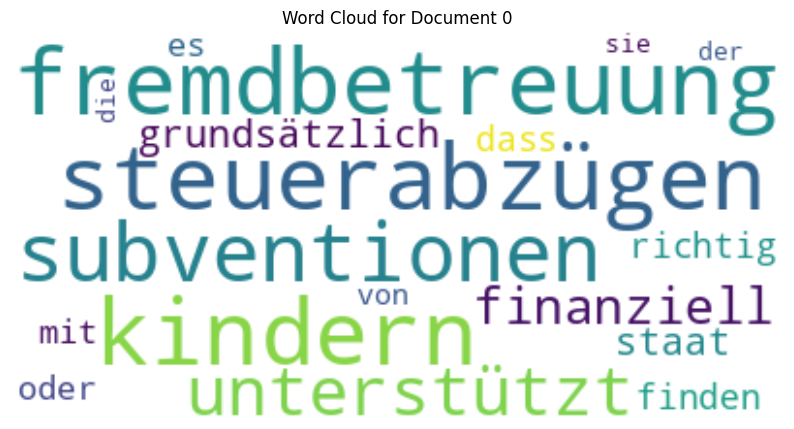

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt


dataset_path = '/content/questions.de.jsonl'
df_de = pd.read_json(dataset_path, lines=True)

texts = df_de['text']

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

def generate_word_cloud_for_document(doc_index):

    scores = tfidf_matrix[doc_index].toarray().flatten()
    scores_dict = {word: scores[idx] for word, idx in tfidf_vectorizer.vocabulary_.items()}

    wordcloud = WordCloud(background_color='white').generate_from_frequencies(scores_dict)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Document {doc_index}')
    plt.show()

generate_word_cloud_for_document(0)


### Let's see the topics discovered by LDA

In [ ]:
def get_topics_lda(topk=10):
  topic_terms = []
  for i in range(num_topics):
      topic_words_list = []
      for word_tuple in lda.get_topic_terms(i, topk):
          topic_words_list.append(dictionary[word_tuple[0]])
      topic_terms.append(topic_words_list)
  return topic_terms

get_topics_lda(5)

[['sie', 'und', 'der', 'die', 'eine'],
 ['die', 'sie', 'der', 'eine', 'werden'],
 ['der', 'die', 'werden', 'sie', 'sollen'],
 ['den', 'bundessteuern', 'nachsten', 'senkungen', 'der'],
 ['die', 'sie', 'werden', 'der', 'auf'],
 ['soll', 'der', 'sich', 'fur', 'starker'],
 ['der', 'soll', 'die', 'werden', 'fur'],
 ['befurworten', 'sie', 'vollstandige', 'liberalisierung', 'kmu'],
 ['den', 'die', 'und', 'der', 'des'],
 ['der', 'werden', 'die', 'von', 'sie'],
 ['sie', 'der', 'befurworten', 'den', 'fur'],
 ['der', 'sie', 'die', 'befurworten', 'eine']]

In [ ]:
cm = CoherenceModel(model=lda, dictionary=dictionary,
                    texts=split_preprocessed_documents, coherence='c_npmi')
lda_coherence = cm.get_coherence()
print("coherence score LDA:", lda_coherence)

coherence score LDA: -0.1666694771705615


In [ ]:
from contextualized_topic_models.evaluation.measures import CoherenceNPMI, InvertedRBO
corpus = [d.split() for d in preprocessed_documents]
coh = CoherenceNPMI(ctm.get_topic_lists(10), corpus)
print("coherence score CTM:", coh.score())

coherence score CTM: -0.2113170351535039


In [ ]:
irbo_lda = InvertedRBO(get_topics_lda(10))
print("diversity score LDA:", irbo_lda.score())

irbo_ctm = InvertedRBO(ctm.get_topic_lists(10))
print("coherence score CTM:", irbo_ctm.score())

diversity score LDA: 0.6218484852444806
coherence score CTM: 0.9917544572392857


In [ ]:
topics_predictions = ctm.training_doc_topic_distributions

Then we get the index of the most likely topic of the document of our choice

In [ ]:
import numpy as np
train_doc_id = 0
topic_id = np.argmax(topics_predictions[train_doc_id])

And finally get the top words of the most likely topic for the considered document.

In [ ]:
ctm.get_topic_lists(10)[topic_id]

['staat',
 'einkommen',
 'fortpflanzungsmedizin',
 'innen',
 'nachhilfe',
 'geringem',
 'starker',
 'schuler',
 'angepasst',
 'gebirgslandeplatzen']

Let us compare it with the original document

In [ ]:
unpreprocessed_corpus[train_doc_id]

'Finden Sie es grundsätzlich richtig, dass der Staat die Fremdbetreuung von Kindern finanziell unterstützt (mit Steuerabzügen oder Subventionen)?'

We can also compare the topic with the corresponding ground truth label.


In [ ]:
print("Original label:", result['topic'][train_doc_id])
print("Most likely topic:", ctm.get_topic_lists(10)[topic_id])

Original label: Welfare
Most likely topic: ['staat', 'einkommen', 'fortpflanzungsmedizin', 'innen', 'nachhilfe', 'geringem', 'starker', 'schuler', 'angepasst', 'gebirgslandeplatzen']


In [ ]:
topic_id = 5
print(ctm.get_topics()[topic_id])

['aus', 'aufnehmen', 'eu', 'bundesrat', 'erhoht', 'wahlen', 'ihren', 'international', 'prinzip', 'strommarktes']


In [ ]:
ctm.get_top_documents_per_topic_id(unpreprocessed_corpus, ctm.training_doc_topic_distributions, topic_id, k=7)

[('Sollten die bestehenden Importerleichterungen für Lebensmittel aus der EU (Cassis-de-Dijon-Prinzip) abgeschafft werden?',
  0.2097744),
 ('Soll die Aufenthaltserlaubnis für Migrant/innen aus Nicht-EU/EFTA-Staaten schweizweit an die Erfüllung verbindlicher Integrationsvereinbarungen geknüpft werden?',
  0.19800209),
 ('Soll sich die Schweizer Aussenpolitik stärker an einer strikten Auslegung der Neutralität orientieren?',
  0.19506824),
 ('Soll der Umwandlungssatz, der die Höhe der BVG-Rente (2. Säule) regelt, an die gestiegene Lebenserwartung angepasst und von 6.8 auf 6.0% gesenkt werden?',
  0.18953541),
 ('Sollte sich die Regionalpolitik des Bundes künftig stärker auf die wirtschaftliche Förderung in Städten und Agglomerationen konzentrieren?',
  0.18749383),
 ('Soll die Schweiz ein Agrarfreihandelsabkommen mit der EU abschliessen?',
  0.18526496),
 ('Soll der Bund Ausländer/-innen bei der Integration stärker unterstützen?',
  0.18183681)]

In [ ]:
fix_seeds()

zero_tp = TopicModelDataPreparation("paraphrase-multilingual-mpnet-base-v2")

zero_training_dataset = zero_tp.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

.gitattributes:   0%|          | 0.00/690 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

And we are ready to train the model. Make sure you use the "ZeroShotTM" class and not the "CombinedTM" one.

In [ ]:
zero_ctm = ZeroShotTM(bow_size=len(zero_tp.vocab), contextual_size=768,
                      n_components=12, num_epochs=50)
zero_ctm.fit(zero_training_dataset)

Epoch: [50/50]	 Seen Samples: [6400/8650]	Train Loss: 111.14826583862305	Time: 0:00:00.164489: : 50it [00:09,  5.01it/s]
100%|██████████| 3/3 [00:00<00:00, 16.83it/s]


### Topics
As before, let us look at the topics of the model


In [ ]:
zero_ctm.get_topic_lists(5)

[['im', 'der', 'liberalisierung', 'haftungsregeln', 'ausland'],
 ['oder', 'schule', 'dem', 'unterrichtet', 'konzept'],
 ['besitz', 'moratorium', 'im', 'unternehmen', 'eu'],
 ['mehr', 'mit', 'sie', 'des', 'agglomerationen'],
 ['lockerung', 'fur', 'haben', 'vergabe', 'schutzbestimmungen'],
 ['fluchtlingshilfswerk',
  'sicherheitsrat',
  'aufnehmen',
  'fluchtlingsgruppen',
  'aus'],
 ['erhohung', 'jahre', 'sie', 'behinderungen', 'auslander'],
 ['eu', 'geschaftsoffnungszeiten', 'abgabe', 'von', 'die'],
 ['auf', 'fortpflanzungsmedizin', 'ausgebaut', 'kosten', 'eines'],
 ['des', 'wirtschaftliche', 'sie', 'angepasst', 'offnungszeiten'],
 ['abgabe', 'schweizerischen', 'renten', 'auf', 'ihren'],
 ['schweiz', 'bauzonen', 'abgabe', 'begrenzt', 'nicht']]

### Let's predict the topics of the documents in unseen languages

It's time to take advantage of the power of multilingual language models. Let's predict the topics of some answers in French, German and Italian. Rembember that these answers are in languages that the model has not seen during training.


 First, we download the data as before.

In [ ]:
!wget https://raw.githubusercontent.com/gayatribandaru/CMPE255_Team_Project_InsightfulMiners/main/test.jsonl

df_test = pd.read_json(path_or_buf='/content/test.jsonl', lines=True)
df_test


--2023-12-16 06:47:41--  https://raw.githubusercontent.com/gayatribandaru/CMPE255_Team_Project_InsightfulMiners/main/test.jsonl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9109367 (8.7M) [text/plain]
Saving to: ‘test.jsonl’

test.jsonl          100%[===================>]   8.69M  --.-KB/s    in 0.09s   

2023-12-16 06:47:42 (98.1 MB/s) - ‘test.jsonl’ saved [9109367/9109367]



,id,language,question_id,question,comment,label,numerical_label,author,topic,test_set
0,17820,de,3415,Sollen die Renten der Pensionskasse durch eine...,Es muss nach anderen Lösungen gesucht werden. ...,AGAINST,25,aea1e176f453,Welfare,new_comments_defr
1,17821,de,3416,Befürworten Sie Bestrebungen in den Kantonen z...,Die Kantone sollen sich um Missbräuche durch L...,AGAINST,25,aea1e176f453,Welfare,new_comments_defr
2,17823,de,3423,Soll sich der Staat stärker für gleiche Bildun...,Bildung ist eines unserer Ressourcen und sollt...,FAVOR,100,aea1e176f453,Education,new_comments_defr
3,17824,de,3446,Soll der Ausbau des Mobilfunknetzes nach 5G-St...,Solange die Auswirkungen auf den Menschen nich...,AGAINST,25,aea1e176f453,Digitisation,new_comments_defr
4,18220,de,3414,Eine Initiative fordert einen bezahlten Vaters...,"Nein, da ich den Gegenvorschlag bezüglich 2 Wo...",AGAINST,0,953e5b52fe06,Welfare,new_comments_defr
...,...,...,...,...,...,...,...,...,...,...
17700,144258,it,3421,Un'iniziativa chiede che il sistema di riduzio...,Questa iniziativa non solo non risolve in alcu...,AGAINST,0,b2a346607f51,Healthcare,new_topics_it
17701,144259,it,3422,Un'iniziativa vorrebbe dare alla Confederazion...,Il budget globale nel sistema sanitario non ha...,AGAINST,25,b2a346607f51,Healthcare,new_topics_it
17702,144280,it,3458,I finanziamenti ai partiti e alle campagne per...,La protezione della sfera privata dei donatori...,AGAINST,25,b2a346607f51,Political System,new_topics_it
17703,144281,it,3459,Ritiene che debba prosequire l'introduzione de...,Solamente una volta garantita la completa sicu...,FAVOR,75,b2a346607f51,Political System,new_topics_it


In [ ]:
df_test['question'][0] + " <SEP> " + df_test['comment'][0]

'Sollen die Renten der Pensionskasse durch eine Senkung des Umwandlungssatzes gekürzt und an die gestiegene Lebenserwartung angepasst werden? <SEP> Es muss nach anderen Lösungen gesucht werden. Die Lebenshaltungskosten (u.a. Mieten) steigen auch weiter.'

Let's concatenate question and answer for all the instances

In [ ]:
test_docs = t[quest + " " + answ for quest, answ in zip(df_test['question'].tolist(), df_test['comment'].tolist())]

In [ ]:
test_docs[:5]

['Sollen die Renten der Pensionskasse durch eine Senkung des Umwandlungssatzes gekürzt und an die gestiegene Lebenserwartung angepasst werden? Es muss nach anderen Lösungen gesucht werden. Die Lebenshaltungskosten (u.a. Mieten) steigen auch weiter.',
 'Befürworten Sie Bestrebungen in den Kantonen zur Senkung der Sozialhilfeleistungen? Die Kantone sollen sich um Missbräuche durch Leistungsbezüger kümmern.',
 'Soll sich der Staat stärker für gleiche Bildungschancen einsetzen (z.B. mit Nachhilfe-Gutscheinen für Schüler/-innen aus Familien mit geringem Einkommen)? Bildung ist eines unserer Ressourcen und sollte wo immer möglich gestärkt werden.',
 'Soll der Ausbau des Mobilfunknetzes nach 5G-Standard weiter vorangetrieben werden? Solange die Auswirkungen auf den Menschen nicht geklärt, soll auf den Ausbau verzichtet werden.',
 'Eine Initiative fordert einen bezahlten Vaterschaftsurlaub von vier Wochen. Befürworten Sie dieses Anliegen? Nein, da ich den Gegenvorschlag bezüglich 2 Wochen unte

In [ ]:
testing_dataset = zero_tp.transform(test_docs)

/usr/local/lib/python3.10/dist-packages/contextualized_topic_models/utils/data_preparation.py:192: UserWarning: The method did not have in input the text_for_bow parameter. This IS EXPECTED if you are using ZeroShotTM in a cross-lingual setting
  warnings.warn(


Batches:   0%|          | 0/89 [00:00<?, ?it/s]

In [ ]:
test_topics_predictions = zero_ctm.get_thetas(testing_dataset, n_samples=10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 277/277 [00:05<00:00, 51.04it/s]


Let's install this machine translation library that we are going to use later.

In [ ]:
%%capture
!pip install deep-translator

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now we can predict the topics of documents in unseen languages. Let's consider a document with an arbitrary index.

In [ ]:
test_document_index=10000
test_docs[test_document_index]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


"La naturalisation devrait-elle être facilitée aux étrangers de la troisième génération? pourquoi attendre 3 générations? je l'ai obtenue à l'époque le jour de mon mariage !"

Let us translate the document, only to check if the model predicts correctly the topics.

In [ ]:
from deep_translator import GoogleTranslator
gt = GoogleTranslator(source='auto', target='en')
translated = gt.translate(test_docs[test_document_index])
translated

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'Should naturalization be made easier for third-generation foreigners? why wait 3 generations? I got it back then on my wedding day!'

Let's get the index of most likely topic of the first document and then show the topic words to see if the topic's prediction is accurate

In [ ]:
topic_number = np.argmax(test_topics_predictions[test_document_index])
zero_ctm.get_topic_lists(15)[topic_number]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['besitz',
 'moratorium',
 'im',
 'unternehmen',
 'eu',
 'wind',
 'soll',
 'geltende',
 'den',
 'geschwindigkeitsubertretungen',
 'ausland',
 'zwischen',
 'paare',
 'papiers',
 'legalisiert']

In [ ]:
topic_id = 1
print(zero_ctm.get_topics()[topic_id])
top_documents = zero_ctm.get_top_documents_per_topic_id(test_docs, test_topics_predictions, topic_id, k=10)
top_documents

['oder', 'schule', 'dem', 'unterrichtet', 'konzept', 'integrativen', 'sexualkundeunterricht', 'kinder', 'gemass', 'schulklassen']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('Gemäss dem Konzept der integrativen Schule werden Kinder mit Lernschwierigkeiten oder Behinderungen grundsätzlich in regulären Schulklassen unterrichtet. Befürworten Sie dies? Integration in die normale Schulklasse, solange es für das betroffene Kind das Beste ist.',
  0.62436414),
 ('Gemäss dem Konzept der integrativen Schule werden Kinder mit Lernschwierigkeiten oder Behinderungen grundsätzlich in regulären Schulklassen unterrichtet. Befürworten Sie dies? Ja, wenn genug Mittel (z.B. für IF-Lehrpersonen) vorhanden sind, um alle Schülerinnen und Schüler individuell zu fördern.',
  0.5709259),
 ('Gemäss dem Konzept der integrativen Schule werden Kinder mit Lernschwierigkeiten oder Behinderungen grundsätzlich in regulären Schulklassen unterrichtet. Befürworten Sie dies? Grundsätzlich ja, aber der Lernerfolg der Klasse wie auch des einzelnen Kindes erfordern zumindest eine gewisse Individualisierung. Ferner kann auch die Konstellation der Klasse ins Gewicht fallen und eine Ausn

Let's translate the documents to check

In [ ]:
for original_doc, probability in top_documents:
  print(gt.translate(original_doc), probability)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


According to the integrative school concept, children with learning difficulties or disabilities are generally taught in regular school classes. Do you support this? Integration into the normal school class, as long as it is best for the child concerned. 0.62436414
According to the integrative school concept, children with learning difficulties or disabilities are generally taught in regular school classes. Do you support this? Yes, if there are enough resources (e.g. for IF teachers) to support all students individually. 0.5709259
According to the integrative school concept, children with learning difficulties or disabilities are generally taught in regular school classes. Do you support this? Basically yes, but the learning success of the class as well as the individual child requires at least a certain degree of individualization. Furthermore, the constellation of the class can also be important and suggest an exception to the rule. Integrative models are important! 0.5682327
Accord

Let's try to assign a label to each discovered topic

In [ ]:
labels = ['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9',
          'topic_10', 'topic_11']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Maybe it's helpful to find the most likely training documents for a given topic

In [ ]:
topic_id = 4
print(zero_ctm.get_topic_lists(10)[topic_id])
ctm.get_top_documents_per_topic_id(unpreprocessed_corpus, zero_ctm.training_doc_topic_distributions, topic_id, k=5)

['lockerung', 'fur', 'haben', 'vergabe', 'schutzbestimmungen', 'permanenter', 'den', 'nutzen', 'strengere', 'senkungen']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('Befürworten Sie eine strengere Kontrolle der Lohngleichheit von Frauen und Männern?',
  0.24263659),
 ('Befürworten Sie eine vollständige Liberalisierung des Strommarktes (auch für KMU und Privathaushalte)?',
  0.2351282),
 ('Würden Sie die Einführung einer Frauenquote in Verwaltungsräten börsenkotierter Unternehmen befürworten?',
  0.22221485),
 ('Befürworten Sie die Einführung einer Kapitalgewinnsteuer auf Wertschriften?',
  0.20305835),
 ('Befürworten Sie strengere Tierschutzregelungen für die Haltung von Nutztieren (z.B. permanenter Zugang zum Aussenbereich)?',
  0.19199903)]

In [ ]:
print(labels,"\n")

zero_ctm.get_topic_lists(5)

['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11'] 



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['im', 'der', 'liberalisierung', 'haftungsregeln', 'ausland'],
 ['oder', 'schule', 'dem', 'unterrichtet', 'konzept'],
 ['besitz', 'moratorium', 'im', 'unternehmen', 'eu'],
 ['mehr', 'mit', 'sie', 'des', 'agglomerationen'],
 ['lockerung', 'fur', 'haben', 'vergabe', 'schutzbestimmungen'],
 ['fluchtlingshilfswerk',
  'sicherheitsrat',
  'aufnehmen',
  'fluchtlingsgruppen',
  'aus'],
 ['erhohung', 'jahre', 'sie', 'behinderungen', 'auslander'],
 ['eu', 'geschaftsoffnungszeiten', 'abgabe', 'von', 'die'],
 ['auf', 'fortpflanzungsmedizin', 'ausgebaut', 'kosten', 'eines'],
 ['des', 'wirtschaftliche', 'sie', 'angepasst', 'offnungszeiten'],
 ['abgabe', 'schweizerischen', 'renten', 'auf', 'ihren'],
 ['schweiz', 'bauzonen', 'abgabe', 'begrenzt', 'nicht']]

# Visualization

visualization techniques of model metrics



Now we can see how the different topics distribute over the whole training corpus

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


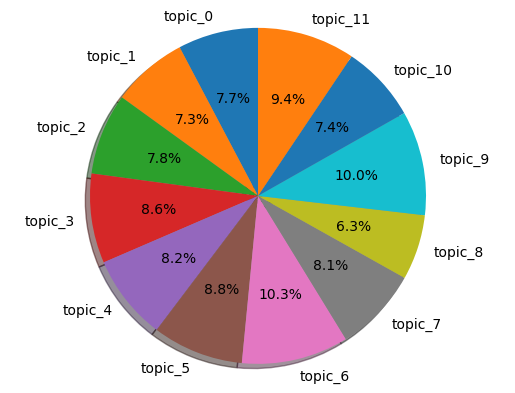

In [ ]:
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots()
ax1.pie(np.average(zero_ctm.training_doc_topic_distributions,axis=0),
        labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()


And we can compare this with the testing corpus

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


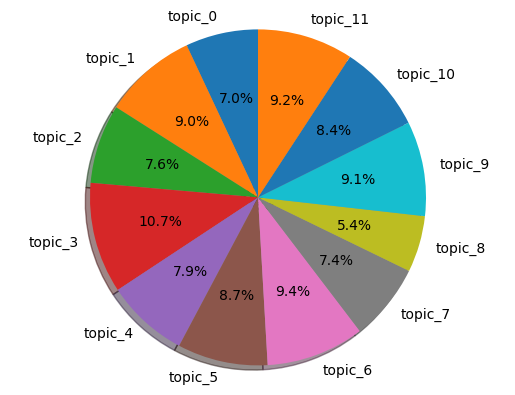

In [ ]:
fig1, ax1 = plt.subplots()
ax1.pie(np.average(test_topics_predictions,axis=0),
        labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()


We can also compare the distribution of the topics between the different languages. Let's split the topic predictions by language.

In [ ]:
test_topics_predictions_it, test_topics_predictions_de, test_topics_predictions_fr = [], [], []
for ttp, lang in zip(test_topics_predictions, df_test['language'].tolist()):
  if lang == 'it':
    test_topics_predictions_it.append(ttp)
  elif lang == 'de':
    test_topics_predictions_de.append(ttp)
  elif lang == 'fr':
    test_topics_predictions_fr.append(ttp)
  else:
    print('something went wrong')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now we are ready to plot the different distributions, as seen above

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


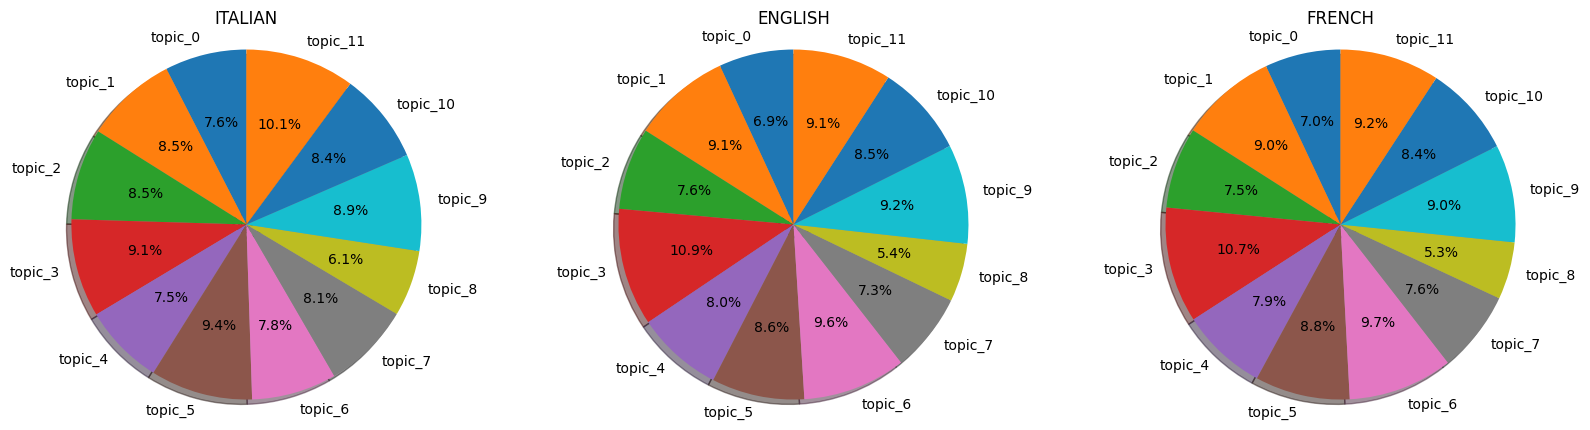

In [ ]:
fig1, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
axs[0].pie(np.average(test_topics_predictions_it,axis=0),
        labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[0].axis('equal')
axs[0].title.set_text('ITALIAN')

axs[1].pie(np.average(test_topics_predictions_de,axis=0),
        labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[1].axis('equal')
axs[1].title.set_text('ENGLISH')


axs[2].pie(np.average(test_topics_predictions_fr,axis=0),
        labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[2].axis('equal')
axs[2].title.set_text('FRENCH')


plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


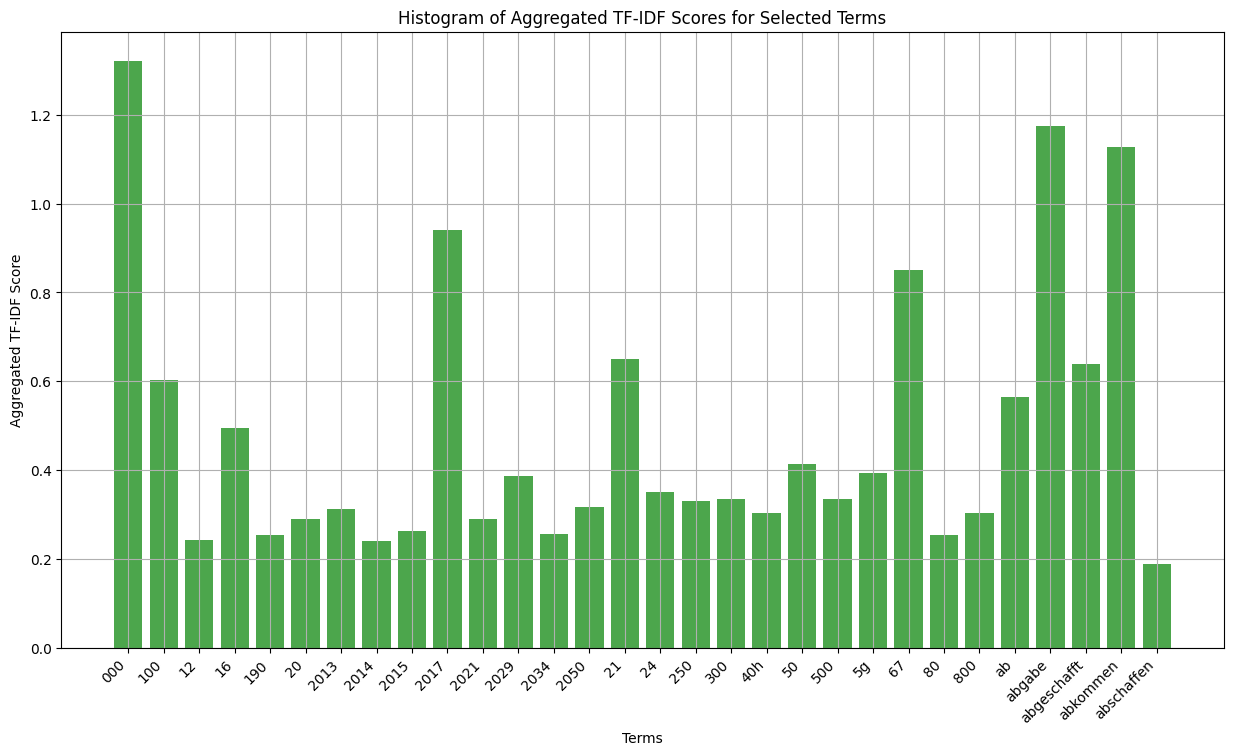

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np


dataset_path = '/content/questions.de.jsonl'
df_de = pd.read_json(dataset_path, lines=True)

texts = df_de['text']

tfidf_vectorizer = TfidfVectorizer(max_features=5000)

tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

aggregated_scores = np.sum(tfidf_matrix.toarray(), axis=0)

selected_terms = tfidf_vectorizer.get_feature_names_out()[:30]
selected_scores = aggregated_scores[:30]

plt.figure(figsize=(15, 8))
plt.bar(selected_terms, selected_scores, color='green', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.title("Histogram of Aggregated TF-IDF Scores for Selected Terms")
plt.xlabel('Terms')
plt.ylabel('Aggregated TF-IDF Score')
plt.grid(True)
plt.show()


# Feedback and Iterative Improvement

### Reflection on Current Outcomes

- In summary, the results indicate that the LDA model effectively detected a range of topics from the dataset. This was confirmed by the function get_topics_lda(topk=10), which generated a list of key words associated with each topic.

- In contrast to the stated objectives, the project successfully implemented Latent Dirichlet Allocation (LDA) to identify significant themes within a German dataset, including but not limited to economic matters, social concerns, and government policies.


### Identifying Areas for Improvement

- Model Performance: The LDA model's computed coherence score may serve as a standard against which further enhancements can be measured. Additional refinement of the model or investigation into sophisticated preprocessing techniques could potentially improve this.

- The model's applicability was limited to a single language (German), indicating potential for further development in the area of multilingual datasets to facilitate more comprehensive analyses.


### Future Steps and Improvements

- Model Enhancement: Investigate sophisticated methods of topic modeling or optimize hyperparameters in order to augment coherence scores.

- Data Expansion: Utilize the capabilities of multilingual models to extend the analysis to additional languages.

- Incorporate machine translation to facilitate comparison and analysis across languages as an additional feature. This may entail making greater use of the installed deep-translator library during the analysis phase.
​

### Action Plan

- Roadmap: Construct a strategic plan outlining the sequential steps required to execute these enhancements, incorporating significant dates for model improvement, data augmentation, and feature incorporation.

- Evaluation Strategy: Develop a plan to conduct periodic reassessments of the model's performance, prioritizing coherence scores and the pertinence of identified topics, with each improvement.


### Conclusion

- Concluding Remarks: The project's iterative nature underscored the possibility of continuous improvement and enhancement in order to more effectively fulfill project goals and user requirements.

